# Load packages

In [1]:
%cd ../RADOM

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from inference import Trajectory
from plotting import *
from models.two_species import get_Y

/home/mffang/workspace/Poisson-regression/RADOM


In [2]:
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare input data

## Download data

In [3]:
!wget --directory-prefix=../data/Barile/ http://bioinformatics.stemcells.cam.ac.uk/mb2338/adata_human_for_velocity.h5

--2022-10-19 14:11:47--  http://bioinformatics.stemcells.cam.ac.uk/mb2338/adata_human_for_velocity.h5
Resolving bioinformatics.stemcells.cam.ac.uk (bioinformatics.stemcells.cam.ac.uk)... 193.60.92.162
Connecting to bioinformatics.stemcells.cam.ac.uk (bioinformatics.stemcells.cam.ac.uk)|193.60.92.162|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 570898457 (544M)
Saving to: ‘../data/adata_human_for_velocity.h5’

adata_human_for_vel 100%[===================>] 544.45M   278KB/s    in 36m 10s 

2022-10-19 14:47:58 (257 KB/s) - ‘../data/adata_human_for_velocity.h5’ saved [570898457/570898457]



In [21]:
!wget --directory-prefix=../data/Barile/ http://bioinformatics.stemcells.cam.ac.uk/mb2338/adata_for_velocity_mouse.h5

--2022-10-19 15:32:42--  http://bioinformatics.stemcells.cam.ac.uk/mb2338/adata_for_velocity_mouse.h5
Resolving bioinformatics.stemcells.cam.ac.uk (bioinformatics.stemcells.cam.ac.uk)... 193.60.92.162
Connecting to bioinformatics.stemcells.cam.ac.uk (bioinformatics.stemcells.cam.ac.uk)|193.60.92.162|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 284710785 (272M)
Saving to: ‘../data/Barile/adata_for_velocity_mouse.h5’

adata_for_velocity_ 100%[===================>] 271.52M   272KB/s    in 21m 30s 

2022-10-19 15:54:14 (215 KB/s) - ‘../data/Barile/adata_for_velocity_mouse.h5’ saved [284710785/284710785]



In [3]:
data_dir = "../data/Barile/"

## Reproduce Fig 3e in Barile et al.

In [24]:
adata = sc.read(data_dir+'adata_for_velocity_mouse.h5')
adata

AnnData object with n_obs × n_vars = 9815 × 3434
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [25]:
celltype_colours = [
"#f9decf",
"#c9a997",
"#C72228",
"#f77b59",
"#EF4E22"]
adata.uns['celltype_colors'] = celltype_colours

In [26]:
scv.pp.filter_and_normalize(adata)

scv.pp.moments(adata, n_neighbors = 50)

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [27]:
scv.tl.recover_dynamics(adata,n_jobs=20)

recovering dynamics (using 20/88 cores)


  0%|          | 0/625 [00:00<?, ?gene/s]

    finished (0:01:05) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [28]:
scv.tl.velocity(adata,mode='dynamical')
scv.tl.velocity_graph(adata,n_jobs=20)

computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 20/88 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


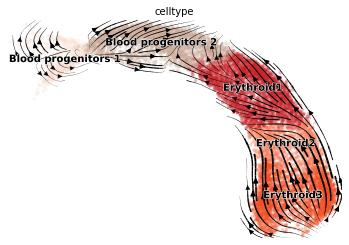

In [29]:
# Plot Figure 3E top left corner

scv.pl.velocity_embedding_stream(adata, basis = "umap", color ="celltype", size = 50)

## Select genes and get X

In [4]:
Data = sc.read(data_dir+'adata_for_velocity_mouse.h5')
Data

AnnData object with n_obs × n_vars = 9815 × 3434
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [5]:
gene_names = Data.var_names

In [6]:
murk_genes = list(pd.read_csv(data_dir+'murk_genes_mouse.txt',sep=" ",header=None)[0])

In [7]:
idx = [np.where(gene_names==gene)[0] for gene in murk_genes]
idx = np.concatenate(idx).ravel()
fitted_genes = gene_names[idx]

In [16]:
n,p = Data[:,idx].X.shape
X = np.zeros((n,p,2))
X[:,:,0]= 10*Data.layers["unspliced"].toarray()[:,idx]
X[:,:,1]= Data.layers["spliced"].toarray()[:,idx]
X.shape

(9815, 89, 2)

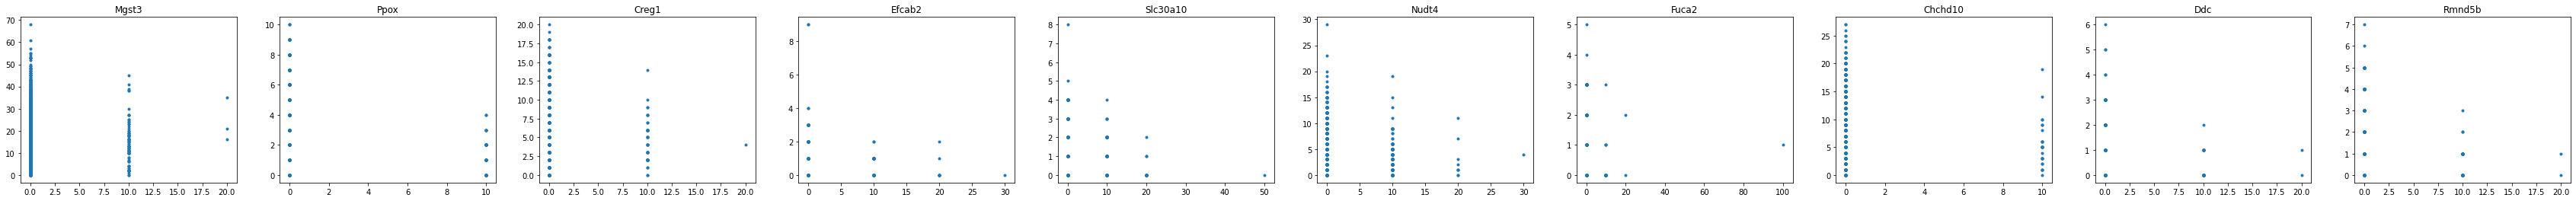

In [17]:
plot_p=10
fig, ax = plt.subplots(1,plot_p,figsize=(6*plot_p,4))
for j in range(plot_p):
    ax[j].plot(X[:,j,0],X[:,j,1],'.')
    ax[j].set_title(gene_names[idx[j]])

# Fitting

In [18]:
cell_types = ['Blood progenitors 1','Blood progenitors 2','Erythroid1','Erythroid2', 'Erythroid3']

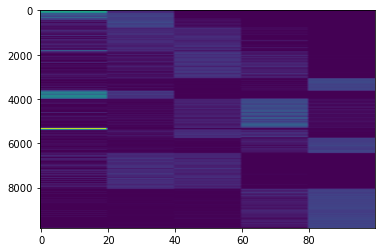

In [19]:
n, p, _ = X.shape
m = 100
Q = np.zeros((n,1,m))
for i,celltype in enumerate(cell_types):
    cell_idx = np.where(Data.obs['celltype'] == celltype)
    Q[cell_idx,:,i*20:(i+1)*20]=1
Q = Q/np.sum(Q,axis=0,keepdims=True)
plt.imshow(Q[:,0],aspect='auto');

In [24]:
topo = np.array([[0,1]])
tau = (0,12,24) # ~24 hours
traj = Trajectory(topo, tau)
res = traj.fit(X,Q=Q,parallel=True,n_threads=2)

run method fit_warm_start


100%|██████████| 20/20 [00:18<00:00,  1.06it/s]


[[ 5.73668253 12.8265412   1.82546681  1.63263822  0.54787766  0.548199  ]
 [ 0.69209686  8.73841592  0.          0.12233833 48.15067104  0.27325411]]


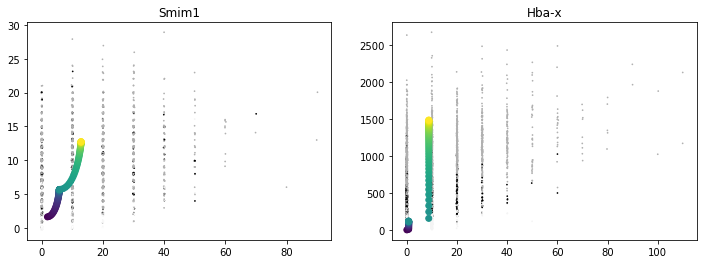

In [25]:
plot_genes = ['Smim1', 'Hba-x',]
plot_idx = [np.where(fitted_genes==gene)[0] for gene in plot_genes]
plot_idx = np.concatenate(plot_idx).ravel()

plot_phase(X,Q,traj,idx=plot_idx,gene_name=fitted_genes)
print(traj.theta[plot_idx])

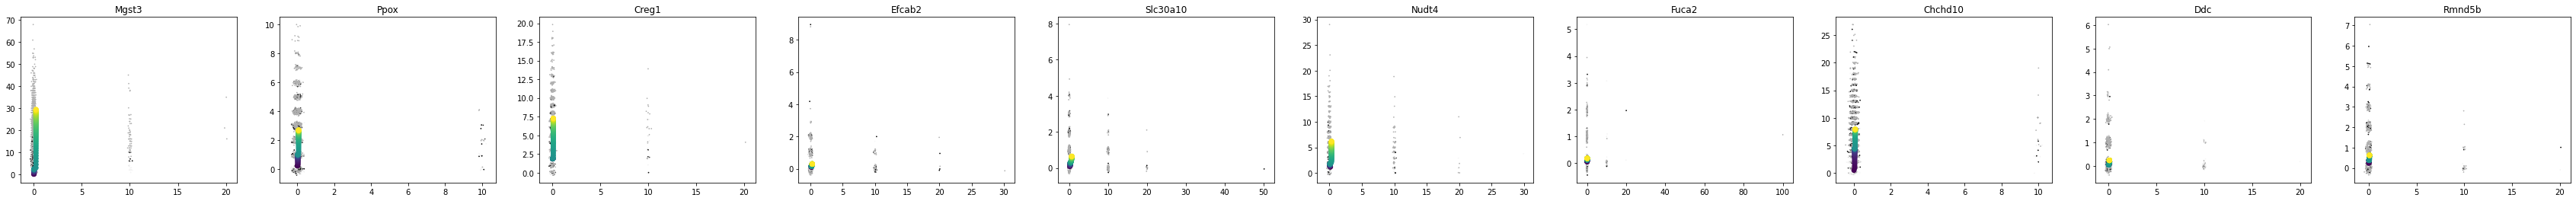

In [26]:
plot_phase(X,Q,traj,idx=np.arange(10),gene_name=fitted_genes)

In [27]:
print(traj.theta[np.arange(10)])

[[1.88446788e-02 2.26250581e-01 0.00000000e+00 1.01374022e-01
  3.05653590e+01 2.19195057e-01]
 [2.49562727e-02 6.55956112e-02 0.00000000e+00 2.46647969e-01
  1.53803689e+01 3.69366439e-01]
 [1.91533028e-02 7.69148139e-02 1.48877614e-02 1.85465041e+00
  2.48205181e+01 2.52413487e-01]
 [1.36282852e-01 2.62411639e-01 1.31574599e-01 9.70538482e-02
  1.54705651e+00 1.38934452e+00]
 [3.01151363e-01 6.45255550e-01 1.34930516e-01 9.10802248e-02
  3.93964123e-01 3.82027469e-01]
 [8.59629350e-02 3.19956849e-01 1.47950031e-01 1.18882382e+00
  3.10763277e+00 1.35377357e-01]
 [5.48925877e-02 8.01638408e-02 0.00000000e+00 5.25873842e-02
  3.08743751e+00 1.44070171e+00]
 [3.58760565e-02 6.35691073e-02 0.00000000e+00 5.39975445e-01
  6.49320073e+01 5.20069242e-01]
 [1.74361689e-02 9.44866841e-02 1.16313183e-01 8.31666425e-02
  2.30503380e+00 9.29412383e-01]
 [5.08315154e-02 8.33902910e-02 0.00000000e+00 2.36402865e-01
  1.30336257e+01 1.75453105e+00]]


Because the unspliced counts are so low, the ratio of beta/gamma has to be very large. In such scenario, there is time scale seperation and phase plot looks like a (part of) rectangle.

**Try different time scale**

run method fit_warm_start


100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


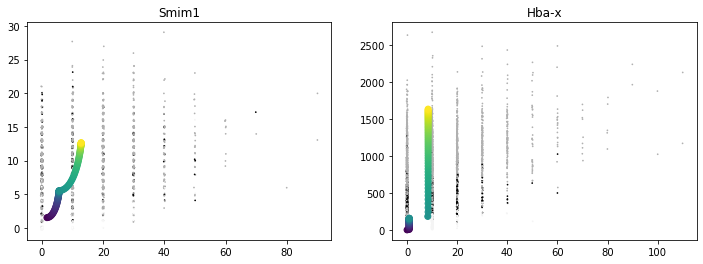

In [22]:
topo = np.array([[0,1]])
tau = (0,4,8) # ~24 hours / mRNA half life 3hs
traj = Trajectory(topo, tau)
res = traj.fit(X,Q=Q,parallel=True,n_threads=2)
plot_phase(X,Q,traj,idx=plot_idx,gene_name=fitted_genes)

In [23]:
print(traj.theta[plot_idx])

[[5.63985692e+00 1.28643937e+01 1.63690493e+00 1.51046083e+00
  1.28634145e+00 1.28624576e+00]
 [8.28826548e-01 8.39184103e+00 0.00000000e+00 9.60894356e-02
  9.99670056e+01 4.27873772e-01]]
